In [1]:
import os
import glob
import re
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
import boto3
s3 = boto3.client('s3')

import dja_sepp

In [2]:
home = "/home/aurelien/DAWN/DJA-SEpp/"
field = 'gds-grizli-v7.2'
fit = 'sersic_rg4'

## Catalog

#### Download catalog files from S3 bucket

In [4]:
# Find files
cat_files = dja_sepp.s3.find_files(bucket='aurelien-sepp', 
                                   path=f'{field}/sepp/{fit}', 
                                   regex=".+tile-\d+_sepp_cat\.fits")
cat_files

['gds-grizli-v7.2-ir_drc_sci_tile-1_sepp_cat.fits',
 'gds-grizli-v7.2-ir_drc_sci_tile-2_sepp_cat.fits']

In [5]:
cat_folder = f"{home}/fields/{field}/sepp/{fit}"
os.makedirs(cat_folder, exist_ok=True)
for file in cat_files:
    print(file)
    s3.download_file('aurelien-sepp', f"{field}/sepp/{fit}/{file}", f"{cat_folder}/{file}")

gds-grizli-v7.2-ir_drc_sci_tile-1_sepp_cat.fits
gds-grizli-v7.2-ir_drc_sci_tile-2_sepp_cat.fits


#### Download DJA catalog

In [10]:
folder = f"{home}/fields/{field}/catalog/dja"
os.makedirs(folder, exist_ok=True)
cat_dja = dja_sepp.s3.find_files(bucket='grizli-v2', 
                                 path='JwstMosaics/v7', 
                                 regex=f"{field}-fix_phot_apcorr.fits")[0]
print(cat_dja)
s3.download_file('grizli-v2', f"JwstMosaics/v7/{cat_dja}", f"{folder}/{cat_dja}")

ceers-full-grizli-v7.2-fix_phot_apcorr.fits


#### Open and merge catalogs

In [6]:
with fits.open(glob.glob(f"{home}/fields/{field}/catalog/dja/*fix_phot_apcorr.fits")[0]) as hdul:
    phot_dja = Table(hdul[1].data)
phot_tiles = []
tiles = glob.glob(f"{home}/fields/{field}/sepp/{fit}/*sci_tile-[!full]*sepp_cat.fits")
tiles.sort(key=lambda filename: int(''.join(filter(str.isdigit, filename))))
for tile in tiles:
    try:
        with fits.open(tile) as hdul:
            phot_tiles.append(Table(hdul[1].data))
    except:
        print(f"Empty catalog: {tile}")

In [7]:
print(f"{'Sources in DJA catalog':<28} : {len(phot_dja)}")
# print(phot_dja.keys())
for i, tile in enumerate(phot_tiles):
    print(f"{f'Sources in SE++ catalog ({i})':<28} : {len(tile)}")
    # print(len(tile.keys()))

Sources in DJA catalog       : 70357
Sources in SE++ catalog (0)  : 4140
Sources in SE++ catalog (1)  : 10654


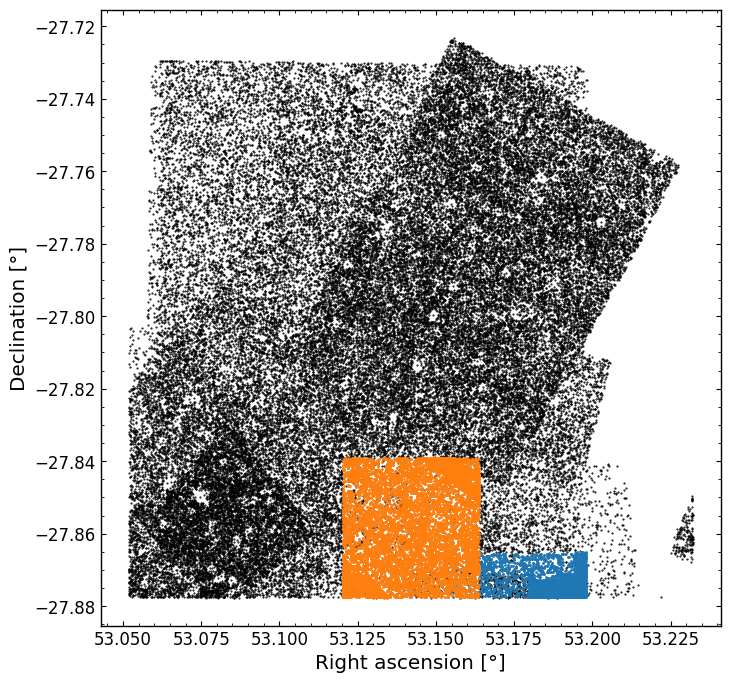

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phot_dja['ra'], phot_dja['dec'], marker='o', ls='', ms=0.5, c='k', label='DJA')
for i, tile in enumerate(phot_tiles):
    ax.plot(tile['world_centroid_alpha'], tile['world_centroid_delta'], marker='o', ls='', ms=1, label=f'SE++ ({i})')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]')
# ax.set_xlim(214.86, 214.98)
# ax.set_ylim(52.82, 52.90)
# ax.legend()
plt.show()

In [9]:
phot_full = dja_sepp.merge_tiles(phot_tiles)
name = re.sub('tile-\d+','tile-full',tiles[0].split('/')[-1])
phot_full.write(f"{home}/fields/{field}/sepp/{fit}/{name}", format='fits', overwrite=True)

#### Upload merged catalog to S3 bucket

In [5]:
s3.upload_file(f"{home}/fields/{field}/sepp/{fit}/{name}", 'aurelien-sepp', f"{field}/sepp/{fit}/{name}")

## Images

#### Download full images from S3 bucket

In [27]:
files = dja_sepp.s3.find_files(bucket='aurelien-sepp', 
                               path=f'{field}/image', 
                               regex=f"^{field}.*(f\d+(w|m)-.*clear_drc).+(sci).*\.fits")
files

['ceers-full-grizli-v7.2-f115w-clear_drc_sci.fits',
 'ceers-full-grizli-v7.2-f150w-clear_drc_sci.fits',
 'ceers-full-grizli-v7.2-f182m-clear_drc_sci.fits',
 'ceers-full-grizli-v7.2-f200w-clear_drc_sci.fits',
 'ceers-full-grizli-v7.2-f210m-clear_drc_sci.fits',
 'ceers-full-grizli-v7.2-f277w-clear_drc_sci.fits',
 'ceers-full-grizli-v7.2-f356w-clear_drc_sci.fits',
 'ceers-full-grizli-v7.2-f410m-clear_drc_sci.fits',
 'ceers-full-grizli-v7.2-f444w-clear_drc_sci.fits']

In [28]:
# Download files
folder = f"{home}/fields/{field}/image"
os.makedirs(folder, exist_ok=True)
for file in files:
    print(file)
    s3.download_file('aurelien-sepp', f"{field}/image/{file}", f"{folder}/{file}")

ceers-full-grizli-v7.2-f115w-clear_drc_sci.fits
ceers-full-grizli-v7.2-f150w-clear_drc_sci.fits
ceers-full-grizli-v7.2-f182m-clear_drc_sci.fits
ceers-full-grizli-v7.2-f200w-clear_drc_sci.fits
ceers-full-grizli-v7.2-f210m-clear_drc_sci.fits
ceers-full-grizli-v7.2-f277w-clear_drc_sci.fits
ceers-full-grizli-v7.2-f356w-clear_drc_sci.fits
ceers-full-grizli-v7.2-f410m-clear_drc_sci.fits
ceers-full-grizli-v7.2-f444w-clear_drc_sci.fits


#### Download tile models from S3 bucket

In [9]:
files = dja_sepp.s3.find_files(bucket='aurelien-sepp', 
                               path=f'{field}/sepp/{fit}/checkimages', 
                               regex=f"^model.+tile-\d+.*\.fits")
files

['model_ceers-full-grizli-v7.2-f115w-clear_drc_sci_tile-full_1.fits',
 'model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-full_1.fits',
 'model_ceers-full-grizli-v7.2-f182m-clear_drc_sci_tile-full_1.fits',
 'model_ceers-full-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits',
 'model_ceers-full-grizli-v7.2-f210m-clear_drc_sci_tile-full_1.fits',
 'model_ceers-full-grizli-v7.2-f277w-clear_drc_sci_tile-full_1.fits',
 'model_ceers-full-grizli-v7.2-f356w-clear_drc_sci_tile-full_1.fits',
 'model_ceers-full-grizli-v7.2-f410m-clear_drc_sci_tile-full_1.fits',
 'model_ceers-full-grizli-v7.2-f444w-clear_drc_sci_tile-full_1.fits',
 'resid_ceers-full-grizli-v7.2-f115w-clear_drc_sci_tile-full_1.fits',
 'resid_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-full_1.fits',
 'resid_ceers-full-grizli-v7.2-f182m-clear_drc_sci_tile-full_1.fits',
 'resid_ceers-full-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits',
 'resid_ceers-full-grizli-v7.2-f210m-clear_drc_sci_tile-full_1.fits',
 'resid_ceers-full-g

In [10]:
# Download files
folder = f'{home}/fields/{field}/sepp/{fit}/checkimages'
os.makedirs(folder, exist_ok=True)
for file in files:
    print(file)
    s3.download_file('aurelien-sepp', f'{field}/sepp/{fit}/checkimages/{file}', f"{folder}/{file}")

model_ceers-full-grizli-v7.2-f115w-clear_drc_sci_tile-full_1.fits
model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-full_1.fits
model_ceers-full-grizli-v7.2-f182m-clear_drc_sci_tile-full_1.fits
model_ceers-full-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits
model_ceers-full-grizli-v7.2-f210m-clear_drc_sci_tile-full_1.fits
model_ceers-full-grizli-v7.2-f277w-clear_drc_sci_tile-full_1.fits
model_ceers-full-grizli-v7.2-f356w-clear_drc_sci_tile-full_1.fits
model_ceers-full-grizli-v7.2-f410m-clear_drc_sci_tile-full_1.fits
model_ceers-full-grizli-v7.2-f444w-clear_drc_sci_tile-full_1.fits
resid_ceers-full-grizli-v7.2-f115w-clear_drc_sci_tile-full_1.fits
resid_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-full_1.fits
resid_ceers-full-grizli-v7.2-f182m-clear_drc_sci_tile-full_1.fits
resid_ceers-full-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits
resid_ceers-full-grizli-v7.2-f210m-clear_drc_sci_tile-full_1.fits
resid_ceers-full-grizli-v7.2-f277w-clear_drc_sci_tile-full_1.fits
resid_ceer

#### Merge model images

In [3]:
# with fits.open(glob.glob(f"{home}/fields/{field}/sepp/{fit}/*sci_tile-full*sepp_cat.fits")[0], memmap=True) as hdul:
#     phot_full = Table(hdul[1].data)
# filter_list = dja_sepp.get_filter_list(phot_full.keys())
filter_list = ['f150w', 'f182m', 'f200w', 'f210m', 'f277w', 'f356w', 'f410m', 'f444w']
with fits.open(glob.glob(f"{home}/fields/{field}/image/*f115w*.fits")[0], memmap=True) as hdul:
    hdu = hdul[0]
    wcs = WCS(hdu.header)
    shape = hdu.data.shape
print("====== Model =======")
dja_sepp.merge_images(f"{home}/fields/{field}/sepp/{fit}/checkimages", filter_list, wcs=wcs, shape=shape, 
                      type='model', suffix="*sci_tile-[!full]*", verbose=True)

====== Model =======
---- F150W ----
F150W : ['/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/sersic_rg4/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-12_1.fits', '/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/sersic_rg4/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-25_1.fits', '/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/sersic_rg4/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-1_1.fits', '/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/sersic_rg4/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-14_1.fits', '/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/sersic_rg4/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-22_1.fits', '/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/sersic_rg4/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-19_1.fits', '/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/sersic_rg4/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_

(WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---TAN' 'DEC--TAN' 
 CRVAL : 214.92 52.87 
 CRPIX : 18432.0 6144.0 
 CD1_1 CD1_2  : -7.1420845520725e-06 -8.5116049235441e-06 
 CD2_1 CD2_2  : -8.5116049235441e-06 7.14208455207265e-06 
 NAXIS : 36864  12288,
 (12288, 36864))

#### Create residual images

In [9]:
for filter in filter_list:
    print(f"---- {filter.upper()} ----")
    with fits.open(glob.glob(f"{home}/fields/{field}/image/*{filter}*.fits")[0], memmap=True) as hdul:
        hdu_data = hdul[0]
        with fits.open(glob.glob(f"{home}/fields/{field}/sepp/{fit}/checkimages/model*{filter}*tile-full*.fits")[0], memmap=True) as hdul_model:
            hdu_model = hdul_model[0].copy()
        hdu_model.header = hdu_data.header
        hdu_model.writeto(glob.glob(f"{home}/fields/{field}/sepp/{fit}/checkimages/model*{filter}*tile-full*.fits")[0], overwrite=True)
        
        data_resid = hdu_data.data - hdu_model.data
        hdu_resid = fits.PrimaryHDU(data_resid, hdu_data.header)
        name = glob.glob(f"{home}/fields/{field}/sepp/{fit}/checkimages/model*{filter}*tile-full*.fits")[0].replace('model', 'resid')
        hdu_resid.writeto(name, overwrite=True)

IndentationError: unexpected indent (3252336080.py, line 2)

#### Upload full model and residual images

In [8]:
for filter in filter_list:
    print(filter.upper())
    # Model
    file = glob.glob(f"{home}/fields/{field}/sepp/{fit}/checkimages/model*{filter}*tile-full*.fits")[0]
    name = file.split("/")[-1]
    s3.upload_file(file, 'aurelien-sepp', f"{field}/sepp/{fit}/checkimages/{name}")
    # Residual
    file = glob.glob(f"{home}/fields/{field}/sepp/{fit}/checkimages/resid*{filter}*tile-full*.fits")[0]
    name = file.split("/")[-1]
    s3.upload_file(file, 'aurelien-sepp', f"{field}/sepp/{fit}/checkimages/{name}")

F115W


# Basic analysis and validation

#### Catalog footprint

In [10]:
with fits.open(glob.glob(f"{home}/fields/{field}/catalog/dja/*fix_phot_apcorr.fits")[0]) as hdul:
    phot_dja = Table(hdul[1].data)
with fits.open(glob.glob(f"{home}/fields/{field}/sepp/{fit}/*sci_tile-full*sepp_cat.fits")[0]) as hdul:
    phot_full = Table(hdul[1].data)

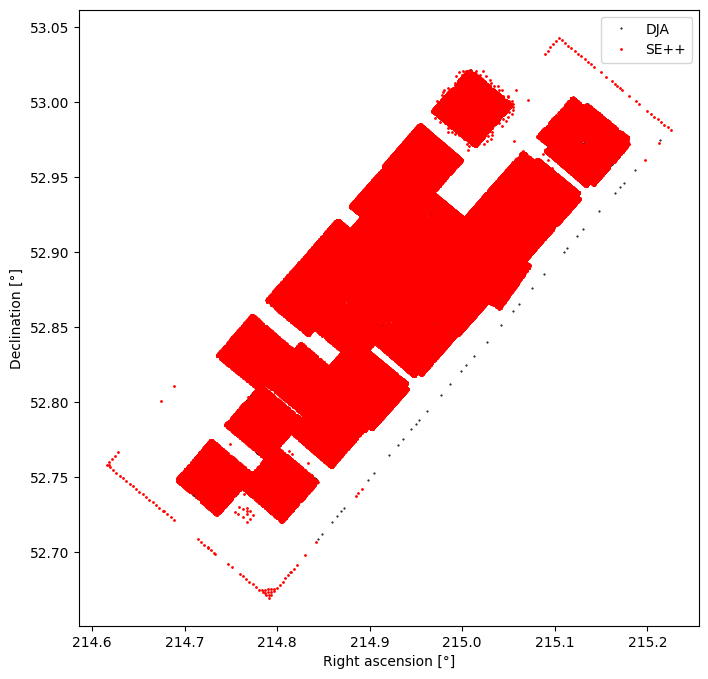

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phot_dja['ra'], phot_dja['dec'], marker='o', ls='', ms=0.5, c='k', label='DJA')
ax.plot(phot_full['world_centroid_alpha'], phot_full['world_centroid_delta'], marker='o', ls='', ms=1, c='r', label=f'SE++')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]')
# ax.set_xlim(214.86, 214.98)
# ax.set_ylim(52.83, 52.90)
ax.legend()
plt.show()

#### Image, model and residual look up

In [17]:
from astropy.visualization import ImageNormalize, ZScaleInterval, MinMaxInterval, LogStretch
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D

filter = 'f444w'

hdu_data = fits.open(glob.glob(f"{home}/fields/{field}/image/*{filter}*.fits")[0], memmap=True)[0]
hdu_model = fits.open(glob.glob(f"{home}/fields/{field}/sepp/{fit}/checkimages/model*{filter}*tile-full*.fits")[0], memmap=True)[0]
hdu_resid = fits.open(glob.glob(f"{home}/fields/{field}/sepp/{fit}/checkimages/resid*{filter}*tile-full*.fits")[0], memmap=True)[0]

In [18]:
# Cutouts in images
center = SkyCoord('14h19m45s 52d54m00s', frame='icrs') # CEERS
size = u.Quantity((2.0,2.0), u.arcmin)
wcs = WCS(hdu_data.header)
cutout_data  = Cutout2D(hdu_data.data,  position=center, size=size, wcs=wcs, mode='partial', fill_value=0.0)
cutout_model = Cutout2D(hdu_model.data, position=center, size=size, wcs=wcs, mode='partial', fill_value=0.0)
cutout_resid = Cutout2D(hdu_resid.data, position=center, size=size, wcs=wcs, mode='partial', fill_value=0.0)

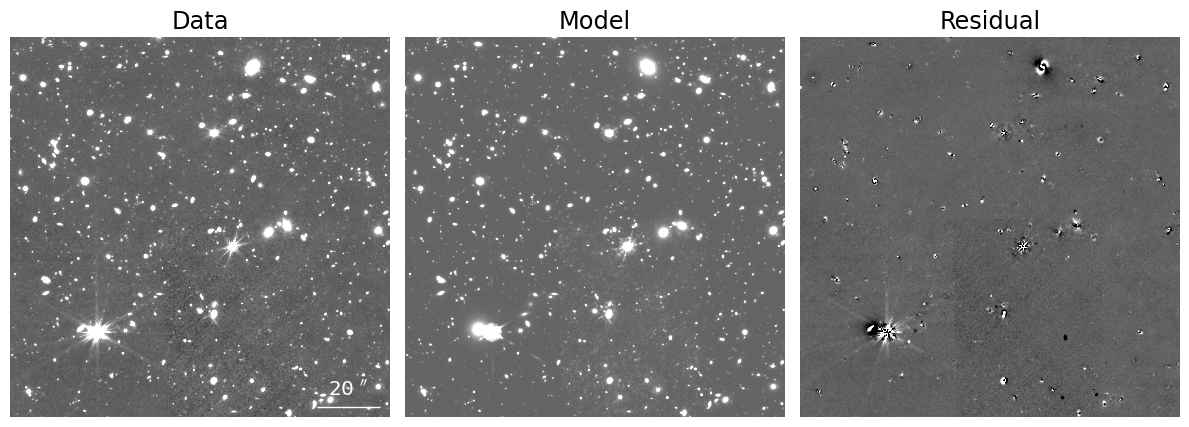

In [19]:
fig = plt.figure(figsize=(12,8))
#Plots data
ax = fig.add_subplot(1,3,1, projection=cutout_data.wcs)
norm = ImageNormalize(cutout_data.data, interval=ZScaleInterval())
ax.imshow(cutout_data.data, cmap='gray', origin='lower', norm=norm)
dja_sepp.utils.add_good_scalebar(ax, cutout_data.wcs)
ax.set_axis_off()
ax.set_title("Data", size='xx-large')
# Plots model
ax_model = fig.add_subplot(1,3,2, projection=cutout_data.wcs)
ax_model.imshow(cutout_model.data, cmap='gray', origin='lower', norm=norm)
ax_model.set_axis_off()
ax_model.set_title("Model", size='xx-large')
# Plots residual
ax_resid = fig.add_subplot(1,3,3, projection=cutout_data.wcs)
ax_resid.imshow(cutout_resid.data, cmap='gray', origin='lower', norm=norm)
ax_resid.set_axis_off()
ax_resid.set_title("Residual", size='xx-large')

fig.tight_layout()
plt.show()